<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Eligible-population-stats" data-toc-modified-id="Eligible-population-stats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eligible population stats</a></span></li></ul></div>

This notebook is from Fall 2022. 
It uses the court data we scraped in October 2021 to model cannabis policy in VA. Note that this is so old I had to change a couple things to get it to work again, so probably worth cross referencing against other more recent policies that use the same dataset and it might warrant some preprocessing updates.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data cleaning
Tip: you'll probably want to save the preprocessed file to a csv the first time you run this for a new policy and then import that csv from then on out to save time. To do so, uncomment the `df.to_csv()` line at the bottom of
this section, then after you run it move that file to `recidiviz-staging>recidiviz>calculator>modeling>population_projection>state>VA>VA_data`. From then on, you can skip everything in the data cleaning section and just run the file import commented out at the end of the section.

In [2]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [3]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\110041657.py:2: DtypeWarning: Colu

In [4]:
sdc_data

,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration,CONSPIRACY,FIRST_DEGREE_MURDER,SECOND_DEGREE_MURDER,CAPITAL_MURDER,OTHER_MURDER,DRUG_POSSESSION,DRUG_SALE,DRUG_OTHER,ARSON,SEX_OFFENSE,DWI,WEAPON,BURGLARY,ROBBERY,LARCENY,ASSAULT,RAPE,KIDNAPPING,MANSLAUGHTER,crimes,CONSPIRACY_ANY,DRUG_POSSESSION_ANY,DRUG_SALE_ANY,DRUG_OTHER_ANY,KIDNAPPING_ANY,MANSLAUGHTER_ANY,LARCENY_ANY,WEAPON_ANY,ASSAULT_ANY,ROBBERY_ANY,BURGLARY_ANY,DWI_ANY,RAPE_ANY,SEX_OFFENSE_ANY,ARSON_ANY,FIRST_DEGREE_MURDER_ANY,SECOND_DEGREE_MURDER_ANY,OTHER_MURDER_ANY,CAPITAL_MURDER_ANY,total_sentence_months,crime_type
0,LYNCHBURG[.] VA 24506,NaN,NaN,NaN,NaN,RECKLESS DRIVING (SP 95/65 MR),Misdemeanor,NaN,46.2-862,General District Court Appeal,Trial - Judge With Witness,NaN,$88.00,License Was Not Surrendered,03/15/****,A GHAYYADA[.] AMER O,12/11/2002,NaN,Yes,10/15/2002,$500.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,08/23/2002,6 Month(s),NaN,NaN,NaN,NaN,White,NaN,NaN,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),Male,NaN,NaN,Louisa Circuit Court,-83.638356,11,12,2002,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),A GHAYYADA[.] AMER O03/15/****LYNCHBURG[.] VA ...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
1,ROANOKE[.] VA 24017,NaN,NaN,NaN,12/05/2012,DRIVING WHILE INTOXICATED[.] 1ST,Misdemeanor,1,A.18.2-266,General District Court Appeal,Trial - Jury,NaN,$1473.00,License Was Not Surrendered,01/09/****,A'SIM[.] ZAHIR RAKIN; JR,02/17/2012,NaN,Yes,06/15/2011,$1250.00,NaN,Jail,NaN,COMMONWEALTH OF VA,NaN,11/20/2010,12 Month(s),NaN,NaN,NaN,NaN,Black,$0.00,NaN,NaN,7 Day(s),Male,No,Yes,Roanoke City Circuit Court,26.558904,17,2,2012,7 Day(s),0,A'SIM[.] ZAHIR RAKIN; JR01/09/****ROANOKE[.] V...,0.230137,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0.230137,DWI
2,WILLIAMSBURG[.] VA 23188,NaN,NaN,NaN,03/05/1997,IMPROPER DRIVING,M,O,46.2-869,General District Court Appeal,Trial - Judge With Witness,NaN,$71.00,NaN,11/03/****,AADAHL[.] CHRISTOPHER P.,06/24/1997,NaN,NaN,04/29/1997,$250.00,Yes,NaN,NaN,COMMONWEALTH OF VA,NaN,03/05/1997,NaN,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,Male,NaN,NaN,York County/Poquoson Circuit Court,-149.210959,24,6,1997,0,0,AADAHL[.] CHRISTOPHER P.11/03/****WILLIAMSBURG...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
3,WOODBRIDGE[.] VA 22191,NaN,NaN,NaN,04/21/2015,AP-G POSSESSION OF MARIJUANA,Misdemeanor,U,18.2-250.1,General District Court Appeal,Trial - Judge With Witness,NaN,$477.50,License Was Not Surrendered,06/19/****,AAGESEN[.] KEVIN MICHAEL,10/01/2015,NaN,NaN,07/09/2015,$350.00,NaN,NaN,NaN,COMMONWEALTH OF VA,NaN,04/21/2015,6 Month(s),NaN,NaN,NaN,NaN,Asian Or Pacific Islander,$0.00,NaN,NaN,NaN,Male,No,NaN,Prince William Circuit Court,70.032877,1,10,2015,0,0,AAGESEN[.] KEVIN MICHAEL06/19/****WOODBRIDGE[....,0.000000,False,False,False,False,False,True,

In [5]:
# Check sentencing data to determine age of offenders when sentenced
raw_sent = pd.concat([
    pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)
])

under_25 = 0
total = 0

for i, row in raw_sent.iterrows():
    sentence_year = row['Calendar Year of Sentencing']
    birth_year = row['Offender Birth Year']
    
    sentencing_age = sentence_year - birth_year
        
    if sentencing_age <= 25:
        under_25 += 1
    
    total += 1
        
# Proportion of inmates incarcerated before 25
INCARCERATED_BEFORE_25 = under_25/total

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\3001792234.py:3: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\3001792234.py:3: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\3001792234.py:3: DtypeWarning: Columns (34,35,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)


In [6]:
sdc_data

,Address,Amended Charge,Amended Charge Type,Amended Code Section,Arrest Date,Charge,Charge Type,Class,CodeSection,Commenced by,Concluded By,ConcurrentConsecutive,Costs,Court/DMV Surrender,DOB,Defendant,Disposition Date,Driver Improvement Clinic,Driving Restrictions,Filed,Fine Amount,Fines/Cost Paid,Jail/Penitentiary,Life/Death,Locality,Military,Offense Date,Operator License Suspension Time,Probation Starts,Probation Time,Probation Type,Program Type,Race,Restitution Amount,Restitution Paid,Sentence Suspended,Sentence Time,Sex,Traffic Fatality,VA Alcohol Safety Action,county,time_step,day,month,year,sentence_time,sentence_suspended,person_id,compartment_duration,CONSPIRACY,FIRST_DEGREE_MURDER,SECOND_DEGREE_MURDER,CAPITAL_MURDER,OTHER_MURDER,DRUG_POSSESSION,DRUG_SALE,DRUG_OTHER,ARSON,SEX_OFFENSE,DWI,WEAPON,BURGLARY,ROBBERY,LARCENY,ASSAULT,RAPE,KIDNAPPING,MANSLAUGHTER,crimes,CONSPIRACY_ANY,DRUG_POSSESSION_ANY,DRUG_SALE_ANY,DRUG_OTHER_ANY,KIDNAPPING_ANY,MANSLAUGHTER_ANY,LARCENY_ANY,WEAPON_ANY,ASSAULT_ANY,ROBBERY_ANY,BURGLARY_ANY,DWI_ANY,RAPE_ANY,SEX_OFFENSE_ANY,ARSON_ANY,FIRST_DEGREE_MURDER_ANY,SECOND_DEGREE_MURDER_ANY,OTHER_MURDER_ANY,CAPITAL_MURDER_ANY,total_sentence_months,crime_type
0,LYNCHBURG[.] VA 24506,NaN,NaN,NaN,NaN,RECKLESS DRIVING (SP 95/65 MR),Misdemeanor,NaN,46.2-862,General District Court Appeal,Trial - Judge With Witness,NaN,$88.00,License Was Not Surrendered,03/15/****,A GHAYYADA[.] AMER O,12/11/2002,NaN,Yes,10/15/2002,$500.00,Yes,Jail,NaN,COMMONWEALTH OF VA,NaN,08/23/2002,6 Month(s),NaN,NaN,NaN,NaN,White,NaN,NaN,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),Male,NaN,NaN,Louisa Circuit Court,-83.638356,11,12,2002,0 Year(s)0 Month(s)90 Day(s),0 Year(s)0 Month(s)90 Day(s),A GHAYYADA[.] AMER O03/15/****LYNCHBURG[.] VA ...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
1,ROANOKE[.] VA 24017,NaN,NaN,NaN,12/05/2012,DRIVING WHILE INTOXICATED[.] 1ST,Misdemeanor,1,A.18.2-266,General District Court Appeal,Trial - Jury,NaN,$1473.00,License Was Not Surrendered,01/09/****,A'SIM[.] ZAHIR RAKIN; JR,02/17/2012,NaN,Yes,06/15/2011,$1250.00,NaN,Jail,NaN,COMMONWEALTH OF VA,NaN,11/20/2010,12 Month(s),NaN,NaN,NaN,NaN,Black,$0.00,NaN,NaN,7 Day(s),Male,No,Yes,Roanoke City Circuit Court,26.558904,17,2,2012,7 Day(s),0,A'SIM[.] ZAHIR RAKIN; JR01/09/****ROANOKE[.] V...,0.230137,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0.230137,DWI
2,WILLIAMSBURG[.] VA 23188,NaN,NaN,NaN,03/05/1997,IMPROPER DRIVING,M,O,46.2-869,General District Court Appeal,Trial - Judge With Witness,NaN,$71.00,NaN,11/03/****,AADAHL[.] CHRISTOPHER P.,06/24/1997,NaN,NaN,04/29/1997,$250.00,Yes,NaN,NaN,COMMONWEALTH OF VA,NaN,03/05/1997,NaN,NaN,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,Male,NaN,NaN,York County/Poquoson Circuit Court,-149.210959,24,6,1997,0,0,AADAHL[.] CHRISTOPHER P.11/03/****WILLIAMSBURG...,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.000000,NaN
3,WOODBRIDGE[.] VA 22191,NaN,NaN,NaN,04/21/2015,AP-G POSSESSION OF MARIJUANA,Misdemeanor,U,18.2-250.1,General District Court Appeal,Trial - Judge With Witness,NaN,$477.50,License Was Not Surrendered,06/19/****,AAGESEN[.] KEVIN MICHAEL,10/01/2015,NaN,NaN,07/09/2015,$350.00,NaN,NaN,NaN,COMMONWEALTH OF VA,NaN,04/21/2015,6 Month(s),NaN,NaN,NaN,NaN,Asian Or Pacific Islander,$0.00,NaN,NaN,NaN,Male,No,NaN,Prince William Circuit Court,70.032877,1,10,2015,0,0,AAGESEN[.] KEVIN MICHAEL06/19/****WOODBRIDGE[....,0.000000,False,False,False,False,False,True,

In [7]:
# This is to make it easier to label data based on violation codes
codes = sdc_data['CodeSection'].unique().astype(str)
charges = sdc_data['Charge'].unique().astype(str)

def containing(a, substr):
    b = []
    for el in a:
        if substr.lower() in el.lower():
            b.append(el)
    return b

containing(codes, "18.2-374.1")

['18.2-374.1',
 '18.2-374.1 B1)',
 '18.2-374.1B2',
 '18.2-374.1-B(2)',
 'B.18.2-374.1',
 '18.2-374.1(B)',
 '18.2-374.1(B[.]2)',
 '18.2-374.1(B)(3',
 '18.2-374.1B3',
 '18.2-374.1(B)4',
 '18.2-374.1(B[.]3)',
 '18.2-374.1(B)(4',
 '18.2-374.1B1&.2',
 '18.2-374.1B(1)',
 '18.2-374.1B(2)',
 '18.2-374.1 B(1)',
 '18.2-374.1(B)2',
 '18.2-374.1A',
 '18.2-374.1B4',
 '18.2-374.1(B[.]1)',
 '18.2-374.1C2',
 '18.2-374.1 B. 2',
 '18.2-374.1(B)(2',
 '18.2-374.1(B)(1',
 '18.2-374.1(B2)',
 '18.2-374.1.1',
 '18.2-374.1(C)',
 'C.18.2-374.1',
 'A.18.2-374.1',
 '18.2-374.1 B.1']

In [8]:
'''
Modeling Assumptions made here:
 - Child-adult distinctions are not made unless under separate codes. Codes are treated under highest severity (ex. in alternative A, 18.2-67.1 committed against an adult is treated as 18.2-67.1 committed against a child)
 - All offenses are assumed repeat where those rules apply (ex. in alternative A, 18.2.30 is always in the 30-year tier)
 - Subsection-level distinctions are not made. If a tier includes some subsection of a code, the whole code is included
 - Inchoate offenses are not factored in
'''
# Note: We can't see repeat offenses in the data as-is, so all rules applying to repeat offenses will be applied to all offense of that type
## This means our model of the policy will generally let people out later, so our estimates will be more conservative
# This also does not include any of the inchoate conviction clauses
# 

policy_scenarios = {
    'original': [
        [],
        [],
        ['F1', '18.2-31', '18.2-30', '18.2-40', '18.2-45', '18.2-46.5', '18.2-46.6', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-274.1', '18.2-355', '18.2-371.1', '18.2-481'],
        ['18.2-32', '18.2-41', '18.2-51', '18.2-51.1', '18.2-51.2', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2.90', '18.2-77', '18.2-79', '18.2-80', '18.2-79', '18.2-80', '18.2-79', '18.2-374.1C', '18.2-374.1(C)'],
        ['F*']
    ],
    'a': [
        [],
        ['F1', '18.2.31', '18.2.30'],
        ['18.2-40', '18.2-45', '18.2-46.5', '18.2-46.6', '18.2-46.6', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-64.2', '18.2-274.1', '18.2-274.1', '18.2-355', '18.2-371.1', '18.2-481'],
        ['18.2-32', '18.2-41', '18.2-51', '18.2-51.1', '18.2-51.2', '18.2-61', '18.2-90', '18.2-77', '18.2-79', '18.2-80', '18.2-374.1'],
        ['F*']
    ],
    'b': [
        ['18.2-31', '18.2-30'],
        [],
        ['18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-46.6', '18.2-274.1', '18.2-40', '18.2-45', '18.2-481', '18.2-371.1'],
        [],
        ['F*']
    ],
    'c': [
        ['18.2.31', '18.2-30'],
        [],
        ['18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-46.6', '18.2-274.1', '18.2-40', '18.2-45', '18.2-481', '18.2-371.1'],
        ['18.2-32', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-51', '18.2-77', '18.2-79', '18.2-80', '18.2-41', '18.2-51', '18.2-51.1', '18.2-79', '18.2-374.1'],
        ['F*']
    ]
}

# Here you can change the version of the bill we're using
scenario = 'b'

In [9]:
sdc_data['Charge Type'].unique()

array(['Misdemeanor', 'M', 'F', 'Felony', 'Infraction', 'Civil', nan,
       'Other (Animal Violations[.] Bond Appeals)', 'I'], dtype=object)

In [10]:
# Add tier column
sdc_data["tier"] = np.nan

In [11]:
sdc_data['Charge Type'].unique()

array(['Misdemeanor', 'M', 'F', 'Felony', 'Infraction', 'Civil', nan,
       'Other (Animal Violations[.] Bond Appeals)', 'I'], dtype=object)

In [12]:
# Assign tiers for a given policy scenario
for tier, tier_codes in enumerate(policy_scenarios[scenario]):
    for code in tier_codes:
        conditions = None
        # Class-1 felonies
        if code == 'F1':
            conditions = (sdc_data['Class'] == '1') & (sdc_data['Charge Type'].isin(['F', 'Felony']))
        # All other felonies
        if code == 'F*':
            conditions = sdc_data['Charge Type'].isin(['F', 'Felony'])
        # Actual codes
        else:
            # This is for catching minor abberations in how codes are written out
            possible_codes = containing(codes, code) + containing(codes, code.replace('-','.'))
            conditions = sdc_data['CodeSection'].isin(possible_codes)   

        sdc_data.loc[conditions & sdc_data['tier'].isna(), 'tier'] = tier

In [13]:
sdc_data.loc[sdc_data['tier'].isna(), 'tier'] = 0 

In [14]:
sdc_data[sdc_data['Charge'] == 'MURDER']['CodeSection']

490        Z.18.2-32
1092       A.18.2-32
1706         18.2-32
1876       A.18.2-32
2872         18.2-32
             ...    
1069348      18.2-32
1069663      18.2-32
1070613      18.2-33
1070928      18.2-33
1071511      18.2-32
Name: CodeSection, Length: 2106, dtype: object

# Preprocessing

## TODOs
* can't just drop 0 length sentences
* recidivism
* separate out jail
* total population (2019/2020 by month)

In [15]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
admissions_data = sorted_data.groupby(['time_step', 'tier']).count()[['Address']].reset_index().rename(
    {'Address': 'cohort_population'}, axis=1
)
admissions_data['compartment'] = 'pretrial'
admissions_data['admission_to'] = 'prison'
admissions_data.cohort_population *= scale_factor
admissions_data = admissions_data[(admissions_data['time_step'] > -108) & (admissions_data['time_step'] <= 33)]
admissions_data.time_step = admissions_data.time_step.astype(int)
admissions_data.cohort_population = admissions_data.cohort_population.astype(float)
admissions_data.head()

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\704529393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


,time_step,tier,cohort_population,compartment,admission_to
936,-107,0.0,228.110816,pretrial,prison
937,-107,2.0,69.931783,pretrial,prison
938,-107,4.0,1753.289699,pretrial,prison
939,-106,0.0,201.470136,pretrial,prison
940,-106,2.0,64.936656,pretrial,prison


In [16]:
tiers = range(int(admissions_data['tier'].max() + 1))

# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'tier'
]).count()[['Address']].reset_index().rename({'Address': 'cohort_portion'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# Leaving out recidivism for now because we don't have stats by tier

# add release transitions as well

# # taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
# RECIDIVISM_BY_CRIME_TYPE = {
#     'ARSON': 0.203,
#     'ASSAULT': 0.246,
#     'BURGLARY': 0.296,
#     'CAPITAL_MURDER': 0.073,
#     'CONSPIRACY': 0.263,
#     'DRUG_OTHER': 0.212,
#     'DRUG_POSSESSION': 0.239,
#     'DRUG_SALE': 0.193,
#     'DWI': 0.184,
#     'FIRST_DEGREE_MURDER': 0.073,
#     'KIDNAPPING': 0.146,
#     'LARCENY': 0.284,
#     'MANSLAUGHTER': 0.105,
#     'OTHER_MURDER': 0.073,
#     'RAPE': 0.226,
#     'ROBBERY': 0.206,
#     'SECOND_DEGREE_MURDER': 0.073,
#     'SEX_OFFENSE': 0.25,        
#     'WEAPON': 0.209
# }

# # taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
# RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
#     6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
#     12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
#     18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
#     24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
#     36: (22.4 + 23.4 + 23.1 + 23.9) / 4
# }
# recidivism_transitions = pd.DataFrame({
#     'compartment': ['release'] * 36,
#     'outflow_to': ['prison'] * 36,
#     'compartment_duration': range(1, 37),
#     'total_population': (
#         [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
#         [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
#         [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
#         [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
#         [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
#     )
# })

# for crime in crime_types:
#     crime_recidivism = recidivism_transitions.copy()
#     total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
#     crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
#     crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
#     crime_recidivism = crime_recidivism.append({
#         'compartment_duration': 36,
#         'total_population': 1 - crime_specific_total_recidivism,
#         'compartment': 'release',
#         'outflow_to': 'release_full',
#     }, ignore_index=True)
#     crime_recidivism['crime_type'] = crime
    
#     transitions_data = transitions_data.append(crime_recidivism)
    
#     # adjust outflows so we're not double counting recidivism
#     outflows_data.loc[
#         outflows_data.crime_type == crime, 'total_population'
#     ] /= 1 + crime_specific_total_recidivism

transitions_data = transitions_data.rename({"total_population": "cohort_portion"})

transitions_data = pd.concat([transitions_data, pd.DataFrame({
    'compartment_duration': [24] * len(tiers),
    'cohort_portion': [1] * len(tiers),
    'compartment': ['release'] * len(tiers),
    'outflow_to': ['release'] * len(tiers),
    'tier': list(tiers),
})], ignore_index=True)

transitions_data.cohort_portion = transitions_data.cohort_portion.astype(float)
transitions_data.head()

,compartment_duration,tier,cohort_portion,compartment,outflow_to
0,1.0,0.0,13453.0,prison,release
1,1.0,2.0,1464.0,prison,release
2,1.0,4.0,25066.0,prison,release
3,2.0,0.0,4245.0,prison,release
4,2.0,2.0,1565.0,prison,release


In [17]:
transitions_data.groupby(["compartment", "outflow_to"]).sum()

,,compartment_duration,tier,cohort_portion
compartment,outflow_to,,,
prison,release,218160.0,2244.0,356811.0
release,release,120.0,10.0,5.0


In [18]:
#Create alternate transitions table for policy scenario

# This estimates resentencing frequency/outcomes using the parole set-off system used in Texas
# see https://www.secondlooktexas.org/action
GRANT_RATE = 3 / (32 + 3)  # SHOULD BE 3 / (32 + 3) -- JUST TESTING

# We don't have data on the distribution of set-off times after each hearing, so doing every other year
SETOFF_TIME = 24
alternate_transitions_data = pd.DataFrame()

# Tiers set by crime type -- tier 0 is not included because it means ineligible
TIERS = transitions_data['tier'].unique().astype("int64")
# Months of sentence that must be served to be eligible for Second Look
TIER_SENTENCE_LENGTHS = [30 * 12, 25 * 12, 20 * 12, 15 * 12]

for tier in TIERS:
    print(tier)
    eligible_data = transitions_data[
        (transitions_data['compartment'] == 'prison')
        & (transitions_data['tier'] == tier)
    ].copy()

    if eligible_data.size > 0 and tier == 0:
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'tier', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = alternate_transitions_data.append(eligible_data)

    elif eligible_data.size > 0 and tier > 0:
        for i in range(TIER_SENTENCE_LENGTHS[tier - 1], int(eligible_data.compartment_duration.max()), SETOFF_TIME):
            rate = GRANT_RATE
            
            # calculate population that still hasn't been released by now
            remaining_population = eligible_data.loc[
                eligible_data['compartment_duration'] > i, 'cohort_portion'
            ].sum()

            print("Total population before", eligible_data['cohort_portion'].sum())
            
            # reduce the population size of people staying in prison longer than this by the number of people being
            # released via resentencing right now
            eligible_data.loc[eligible_data['compartment_duration'] > i, 'cohort_portion'] *= 1 - rate
            
            # add in rows of data for the people being released right now via resentencing
            eligible_data = eligible_data.append({
                'compartment_duration': i,
                'cohort_portion': rate*remaining_population,
                'tier': tier,
                'compartment': 'prison',
                'outflow_to': 'release'
            }, ignore_index=True)

            print("Total population after", eligible_data['cohort_portion'].sum())
        
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'tier', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = alternate_transitions_data.append(eligible_data)

# Round population numbers to avoid tiny populations in weird places
alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.apply(lambda x: round(x, 5))
# drop the rows that are now rounded to zero
alternate_transitions_data = alternate_transitions_data[alternate_transitions_data.cohort_portion > 0]

alternate_transitions_data = alternate_transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(tiers),
    'cohort_portion': [1] * len(tiers),
    'compartment': ['release'] * len(tiers),
    'outflow_to': ['release'] * len(tiers),
    'tier': list(tiers),
}), ignore_index=True)

alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.astype(float)
alternate_transitions_data.head()

0
2
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population after 14770.0
Total population before 14770.0
Total population af

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\1031635708.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append(eligible_data)
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\1031635708.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\1031635708.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\1031635708.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eligible_data = eligible_data.ap

,compartment,compartment_duration,tier,outflow_to,cohort_portion
0,prison,1.0,0.0,release,13453.0
1,prison,2.0,0.0,release,4245.0
2,prison,3.0,0.0,release,3593.0
3,prison,4.0,0.0,release,1500.0
4,prison,5.0,0.0,release,5134.0


In [19]:
print((transitions_data.compartment_duration * transitions_data.cohort_portion).sum())
print((alternate_transitions_data.compartment_duration * alternate_transitions_data.cohort_portion).sum())

7878425.0
7620193.520070001


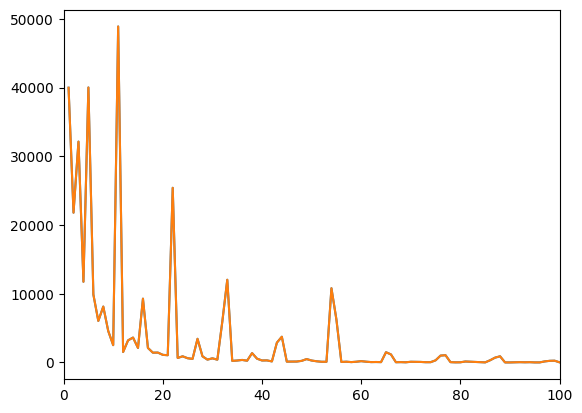

In [20]:
import matplotlib.pyplot as plt

policy_dist = alternate_transitions_data.groupby(['compartment_duration'])['cohort_portion'].sum()
control_dist = transitions_data.groupby(['compartment_duration'])['cohort_portion'].sum()

# They're the same, as we'd expect -- same cohort portion, just with different sentences
plt.plot(control_dist),
plt.plot(policy_dist)
plt.xlim(0,100)
plt.show()

(array([3.47449e+05, 6.19500e+03, 1.73300e+03, 7.12000e+02, 3.46000e+02,
        9.90000e+01, 3.40000e+01, 3.40000e+01, 1.00000e+01, 1.99000e+02]),
 array([5.01336986e-01, 1.10224356e+02, 2.19947375e+02, 3.29670395e+02,
        4.39393414e+02, 5.49116433e+02, 6.58839452e+02, 7.68562471e+02,
        8.78285490e+02, 9.88008510e+02, 1.09773153e+03]),
 <BarContainer object of 10 artists>)

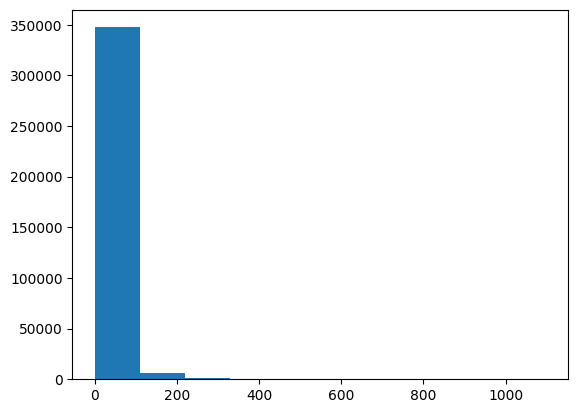

In [21]:
# print(len(sorted_data.LOS))
# print(len(sorted_data[sorted_data["LOS"] > 25*12]))
# over_25 = sorted_data[sorted_data["LOS"] > 25*12]
# over_25.LOS

plt.hist(sorted_data.LOS)

In [22]:
max_duration = transitions_data['compartment_duration'].max()

for tier in alternate_transitions_data['tier'].unique():
    alternate_transitions_data.append({
        'compartment_duration': max_duration,
        'tier': tier,
        'cohort_portion': 1e-5,
        'compartment': 'prison',
        'outflow_to': 'release'
    }, ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\845213628.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\845213628.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\845213628.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\845213628.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data.append({
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\84

In [23]:
transitions_data.head()

,compartment_duration,tier,cohort_portion,compartment,outflow_to
0,1.0,0.0,13453.0,prison,release
1,1.0,2.0,1464.0,prison,release
2,1.0,4.0,25066.0,prison,release
3,2.0,0.0,4245.0,prison,release
4,2.0,2.0,1565.0,prison,release


In [24]:
alternate_transitions_data.tier.unique()

array([0., 2., 4., 1., 3.])

In [25]:
alternate_transitions_data.head()

,compartment,compartment_duration,tier,outflow_to,cohort_portion
0,prison,1.0,0.0,release,13453.0
1,prison,2.0,0.0,release,4245.0
2,prison,3.0,0.0,release,3593.0
3,prison,4.0,0.0,release,1500.0
4,prison,5.0,0.0,release,5134.0


In [26]:
# # Display comparison of populations for TIER 2
# TIER = 2
# alt_data = alternate_transitions_data[alternate_transitions_data['tier'] == TIER]
# og_data = transitions_data[(transitions_data['tier'] == TIER) & (transitions_data.compartment == 'prison')]
# alt_data.index = alt_data.compartment_duration
# og_data.index = og_data.compartment_duration

# display_df = pd.DataFrame()
# display_df['og'] = og_data.cohort_portion
# display_df['alternate'] = alt_data.cohort_portion

# display_df

In [27]:
# change names to fit model expectations
admissions_data = admissions_data.rename(
    {'tier': 'simulation_group'},
    axis=1
)
admissions_data['simulation_group'] = admissions_data['simulation_group'].astype(str)
admissions_data['time_step'] = admissions_data['time_step'].astype('int64')

transitions_data = transitions_data.rename(
    {'tier': 'simulation_group'},
    axis=1
)
transitions_data['simulation_group'] = transitions_data['simulation_group'].astype(str)

alternate_transitions_data = alternate_transitions_data.rename(
    {'tier': 'simulation_group'},
    axis=1
)
alternate_transitions_data['simulation_group'] = alternate_transitions_data['simulation_group'].astype(str)

<Axes: xlabel='time_step'>

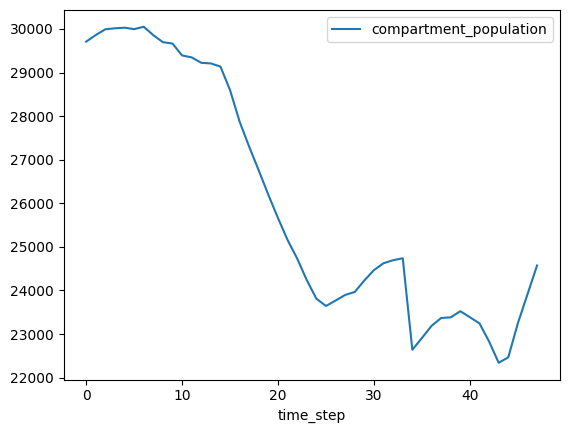

In [52]:
# Total population data

total_pop = {
    2022: [],#[23187, 23368, 23383, 23524, 23386, 23244, 22830, 22341, 22466, 23248, 23910, 24573],
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],#, 22640, 22910],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
}

monthly_populations =  total_pop[2019] + total_pop[2020] + total_pop[2021] + total_pop[2022]
# POTENTIAL ISSUE: People released are still part of the model but not counted here
population_data = pd.DataFrame({
    'time_step': range(len(monthly_populations)),
    'compartment_population': monthly_populations
})
population_data['compartment'] = 'prison'
population_data['compartment_population'] = population_data['compartment_population'].astype(float)

population_data.plot(x='time_step', y='compartment_population')

In [54]:
# Ensure admissions has data for each simulation group
for i in range(-107, population_data['time_step'].max()):
    admissions_data = admissions_data.append([{
        'time_step': i,
        'simulation_group': '0.0',
        'compartment': 'pretrial',
        'cohort_population': 1e-5,
        'admission_to': 'prison'
    }, {
        'time_step': i,
        'simulation_group': '1.0',
        'compartment': 'pretrial',
        'cohort_population': 1e-5,
        'admission_to': 'prison'
    }, {
        'time_step': i,
        'simulation_group': '2.0',
        'compartment': 'pretrial',
        'cohort_population': 1e-5,
        'admission_to': 'prison'
    }, {
        'time_step': i,
        'simulation_group': '3.0',
        'compartment': 'pretrial',
        'cohort_population': 1e-5,
        'admission_to': 'prison'
    }, {
        'time_step': i,
        'simulation_group': '4.0',
        'compartment': 'pretrial',
        'cohort_population': 1e-5,
        'admission_to': 'prison'
    }], ignore_index = True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\407016176.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  admissions_data = admissions_data.append([{
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\407016176.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  admissions_data = admissions_data.append([{
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\407016176.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  admissions_data = admissions_data.append([{
C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\407016176.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  admissions_data = admissions_data.append([{
C:\Users\isaac\AppDa

In [55]:
# Ensure transitions has data for each simulation group
transitions_data = transitions_data.append([{
    'simulation_group': '0.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '1.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '2.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '3.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '4.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}], ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\2874542953.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_data = transitions_data.append([{


In [56]:
# Ensure alternate transitions has data for each simulation group
alternate_transitions_data = alternate_transitions_data.append([{
    'simulation_group': '0.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '1.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '2.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '3.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}, {
    'simulation_group': '4.0',
    'compartment': 'prison',
    'compartment_duration': 24,
    'cohort_portion': 1e-5,
    'outflow_to': 'release'
}], ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\1010815043.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  alternate_transitions_data = alternate_transitions_data.append([{


In [57]:
# transitions_data[transitions_data["compartment"] == "prison"]
transitions_data.groupby(['simulation_group', 'compartment']).sum()

C:\Users\isaac\AppData\Local\Temp\ipykernel_28852\4223615364.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transitions_data.groupby(['simulation_group', 'compartment']).sum()


compartment_duration  cohort_portion
simulation_group compartment                                      
0.0              prison                    38632.0     47891.00003
                 release                      24.0         1.00000
1.0              prison                       72.0         0.00003
                 release                      24.0         1.00000
2.0              prison                    37061.0     14770.00003
                 release                      24.0         1.00000
3.0              prison                       72.0         0.00003
                 release                      24.0         1.00000
4.0              prison                   142683.0    294150.00003
                 release                      24.0         1.00000

In [58]:
alternate_transitions_data.sort_values('cohort_portion', ascending=True)

,compartment,compartment_duration,simulation_group,outflow_to,cohort_portion
914,prison,24.0,4.0,release,0.00001
900,prison,24.0,0.0,release,0.00001
903,prison,24.0,3.0,release,0.00001
901,prison,24.0,1.0,release,0.00001
913,prison,24.0,3.0,release,0.00001
...,...,...,...,...,...
440,prison,22.0,4.0,release,18447.00000
419,prison,1.0,4.0,release,25066.00000
421,prison,3.0,4.0,release,27983.00000
423,prison,5.0,4.0,release,34026.00000


In [59]:
print(transitions_data.cohort_portion.sum())
print(alternate_transitions_data.cohort_portion.sum())

356816.00015
356816.0003


In [60]:
simulation_tag = "second_look_subs" + scenario

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    admissions_data,
    transitions_data,  # Trying just as a way to get around later bug, but I think you need to actually swap transitions for alternate
    population_data,
    '../state/VA/2024/VA_HB834_model_inputs.yaml',
)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [61]:
admissions_data

,time_step,simulation_group,cohort_population,compartment,admission_to
0,-107,0.0,228.110816,pretrial,prison
1,-107,2.0,69.931783,pretrial,prison
2,-107,4.0,1753.289699,pretrial,prison
3,-106,0.0,201.470136,pretrial,prison
4,-106,2.0,64.936656,pretrial,prison
...,...,...,...,...,...
3303,46,0.0,0.000010,pretrial,prison
3304,46,1.0,0.000010,pretrial,prison
3305,46,2.0,0.000010,pretrial,prison
3306,46,3.0,0.000010,pretrial,prison


# Modeling

In [64]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2024/VA_HB834_model_inputs.yaml'
)

Downloading: |                                                                                                        |


ValueError: Cannot set a DataFrame with multiple columns to the single column time_step

In [ ]:
# admissions_data['compartment'].unique()
transitions_data[transitions_data["outflow_to"] == "release"]

In [ ]:
spark_sim.simulate_baseline(['prison'])

In [ ]:
spark_sim.get_arima_output_plots('baseline_projections')

In [ ]:
# before_table_input.to_csv('~/Desktop/debug/before_table_input.csv')
# normalized_df.to_csv('~/Desktop/debug/normalized_df.csv')
# outflow_scaled_releases.to_csv('~/Desktop/debug/outflow_scaled_releases.csv')
# table.to_csv('~/Desktop/debug/table.csv')
# outflow_scaled_remaining.to_csv('~/Desktop/debug/outflow_scaled_remaining.csv')
# after_remaining.to_csv('~/Desktop/debug/after_remaining.csv')
# before_remaining.to_csv('~/Desktop/debug/before_remaining.csv')
# before_table.to_csv('~/Desktop/debug/before_table.csv')

# normalized_df = outflow_scaled_releases.div(
#     outflow_scaled_remaining, axis=0
# )

# normalized_df.liberty = normalized_df.liberty.replace(
#     [np.inf, -np.inf], np.NaN
# ).fillna(1)

# normalized_df.fillna(0.0, inplace=True)
# normalized_df.clip(0, 1, inplace=True)
# normalized_df = normalized_df.apply(lambda x: round(x, SIG_FIGS))

# # Assign the residual probability as the proportion that remains in the current compartment per month
# normalized_df["remaining"] = 1 - round(
#     normalized_df.sum(axis=1), SIG_FIGS - 1
# )

# # Check that the transition table is valid
# full_release_times = np.isclose(normalized_df["remaining"], 0, SIG_FIGS)

# if full_release_times.sum() == 0:
#     import pdb

#     pdb.set_trace()
#     raise ValueError(
#         f"Transition table doesn't release everyone: "
#         f"{normalized_df.iloc[-1]}"
#     )

In [ ]:
alternate_transitions_data['compartment_duration'].max()

In [ ]:
def second_look(tier):
    return SparkPolicy(
        spark_compartment='prison',
        simulation_group=tier,
        alternate_transitions_data=alternate_transitions_data[alternate_transitions_data['simulation_group'] == tier],
        apply_retroactive=True,
        policy_time_step=60 # Start in FY 2024 (60 timesteps after FY 2019)
    )

simulation_groups = ["0.0", "1.0", "2.0", "3.0", "4.0"]
policy_list = []
for tier in simulation_groups:
    policy_list.append(second_look(tier))

test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [ ]:
test_results['control_compartment_population'] - test_tesults['policy_compartment_population']

In [ ]:
# a = alternate_transitions_data[alternate_transitions_data.crime_type == 'RAPE']
# a['t'] = a.total_population.cumsum() / a.total_population.sum()
# a.plot(y='t', x='compartment_duration', ylim=[0.9,None], xlim=[None, 4000])

In [ ]:
# test_results[test_results.compartment == 'prison'].apply(lambda x: x.control_total_population - x.policy_total_population, axis=1)

In [ ]:
# for crime in crime_types:
#     if alternate_transitions_data[alternate_transitions_data.crime_type == crime].compartment_duration.max() < 5:
#         print(alternate_transitions_data[alternate_transitions_data.crime_type == crime])

In [ ]:
simulation_tag = 'second_look_' + scenario
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)